In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot, JLD
include("zz_structures.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

In [2]:
X = load("GZZ_data.jld", "X")
y = load("GZZ_data.jld", "y")
ξ_true = load("GZZ_data.jld", "xi_true");

d, Nobs = size(X)
mb_size = Int(round(Nobs/10))
σ02 = 1
prior = NG_prior(d, σ02)

NG_prior(50, 1.0, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 1.0, 1.0, 1.0, 1.0)

In [3]:
my_ll = ll_logistic(X,y);
my_model = model(my_ll, prior)
root = find_root(my_model, rand(d));

In [4]:
# Sub-Sampling without control variate and with weights
ϵ = 1e-2
weights = abs.(X) + ϵ
weights ./= sum(weights,2)
gs = [wumbsampler(Nobs, mb_size, weights[i,:]) for i in 1:d]
gs_list = mbsampler_list(d,gs);

In [5]:
A = eye(d)

opf = projopf(A, 100, hyperparam_size(prior))
opt = maxa_opt(10^7)
outp = outputscheduler(opf,opt)
bb = linear_bound(my_model.ll, my_model.pr, gs_list, zz_state(opf))
update_bound(bb, my_ll, prior, gs_list, zz_state(opf));

In [6]:
print("Initial speed = ", opf.alpha_skeleton[:,opf.tcounter+1])

Initial speed = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [7]:
adapt_speed = false
L = 1
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(1.)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

In [8]:
start = time()
ZZ_block_sample(my_model::model, outp::outputscheduler, blocksampler::Array{msampler})
print( round((time()-start)/60, 2), " mins")

42.65 mins

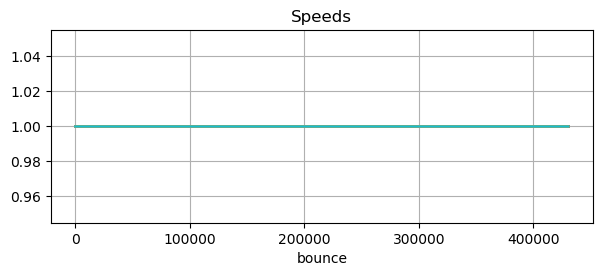

In [9]:
fig = figure("pyplot_barplot",figsize=(7,2.5))
for i in 1:d 
    plot((outp.opf.alpha_skeleton[i,:]))
end
title("Speeds")
xlabel("bounce")
# ylim(0,4000)
grid(true)

In [10]:
discard = 0
n_samples = 10^4
xi_samples = extract_samples(outp.opf.xi_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[end]/n_samples,
                             "linear")[:,1:end-1];

In [11]:
maxlag = 1000
acfs = zeros(d, maxlag)
for i in 1:d 
    acfs[i,:] = acf(xi_samples[i,:], maxlag)
end

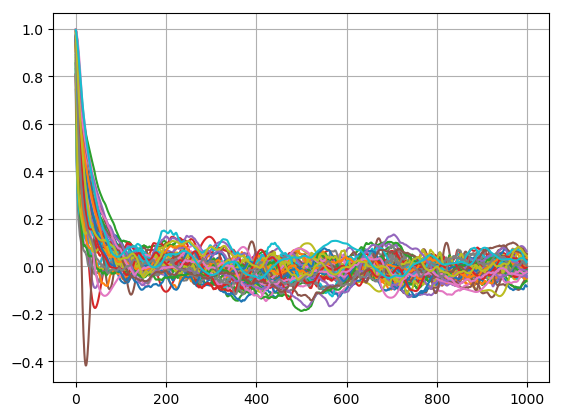

In [12]:
for i in 1:d 
    plot(acfs[i,:])
end
grid(true)

In [13]:
for i in 1:d 
    ci = percentile(xi_samples[i,:], [5, 95])
    print((ci[1]<ξ_true[i])&(ξ_true[i]<ci[2]), "\n")
end

false
false
false
false
true
true
false
true
true
true
true
true
true
true
false
false
false
true
false
false
true
false
true
false
false
true
true
true
true
false
false
true
true
true
true
false
true
true
true
false
false
true
true
false
true
true
false
true
false
false
